# CNN-RNN for force detection

The following notebook proposes an architecture where the original images from the camera are encoded to a latent space representation using convolutional layers and then fed as sequencies of specific size to a recursive neural net.

## Module imports

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import random
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

## Dataset statistics

In [2]:
# Prepare Dataset
# load data

# relative path to npz files
path = 'Measurements/batches_multisine_att_comb'
file_name = 'output_batch_%d.npz'

def load_file(path, batch_id):
    """
    Loads in the memory a specific batch located in the given path.

    Returns a numpy NpzFile object with the image frames np array named
    as "frames" and the force measurements named as "frames".
    """
    combined_path = os.path.join(path,file_name %i)
    data = np.load(combined_path)
    return data

In [3]:
# You can either load the dataset and compute statistics on the spot, or if you know them already skip this step. Comment and uncomment Sections 1 and 2 according to your wish.
# Section 1: Get dataset statistics for normalization
files_num = 10 # how many files to load
file_means = []
file_stds = []

# Compute mean and standard deviation for each file
for i in range(files_num):
    data = load_file(path, i)
    frames = data['frames']
    forces = data['forces'][:, 2]  # Assuming the column containing forces is the third one
    
    # Compute mean and standard deviation for frames
    frames_mean = np.mean(frames)
    frames_std = np.std(frames)
    
    # Compute mean and standard deviation for forces
    forces_mean = np.mean(forces)
    forces_std = np.std(forces)
    
    file_means.append((frames_mean, forces_mean))
    file_stds.append((frames_std, forces_std))

# Average mean and standard deviation across all files
frames_mean = np.mean([mean[0] for mean in file_means])
forces_z_mean = np.mean([mean[1] for mean in file_means])
frames_std = np.mean([std[0] for std in file_stds])
forces_z_std = np.mean([std[1] for std in file_stds])

message = f"The mean pixel value is {frames_mean}, with a standard deviation of {frames_std}." 
message2 = f"The mean force in the Z direction is {forces_z_mean}, with a standard deviation of {forces_z_std}."
print(message)
print(message2)

The mean pixel value is 176.85697274331275, with a standard deviation of 84.01069015654554.
The mean force in the Z direction is 0.06491058804476632, with a standard deviation of 1.3482504253792436.


In [4]:
# Section 2: Dataset statistics hardcoded instead of computing every time:
# frames_mean = 176.85697274331278
# frames_std = 84.01069015654554
# forces_z_mean = 0.06491058804476633
# forces_z_std = 1.3482504253792438
# message = f"The mean pixel value is {frames_mean}, with a standard deviation of {frames_std}." 
# message2 = f"The mean force in the Z direction is {forces_z_mean}, with a standard deviation of {forces_z_std}."
# print(message)
# print(message2)

## Model Architecture

In [3]:
# Create RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_channels, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, 9, kernel_size = 5, stride = 1, padding = 2)
        self.pool = nn.MaxPool2d(kernel_size = 4, stride = 4)
        self.conv2 = nn.Conv2d(9, 18, kernel_size = 5, stride = 1, padding = 2)
        
        # RNN
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(18 * 16 * 30, hidden_dim, layer_dim, batch_first=True, dropout = 0.2, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Convolutional layers
        x = self.pool(nn.ELU()(self.conv1(x)))
        x = self.pool(nn.ELU()(self.conv2(x)))
        
        # Reshape for RNN
        x = torch.reshape(x, (1, 200, 18 * 16 * 30))  # Reshape to (batch_size, seq_len, input_size)
        
        # RNN
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        out, hn = self.rnn(x, h0)
        
        # Output layer
        out = self.fc(out) 
        out = torch.reshape(out, (200, 1)) # go back to compare to labels
        return out

In [6]:
# Create RNN
input_channels = 3  # RGB channels
hidden_dim = 200  # hidden layer dimension
layer_dim = 2     # number of hidden layers
output_dim = 1   # output dimension

model = RNNModel(input_channels, hidden_dim, layer_dim, output_dim)
# Load previous model if you'd like:
model.load_state_dict(torch.load('best_model_epoch_8.pth'))

# Define your loss function
error = nn.MSELoss()

# Define your optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [7]:
# Training parameters
file_size = 1000 # one file contains 1000 samples
num_epochs = 10
batch_size = 200 # should be something that leaves zero reminder when it divides the file_size
files_num = 10 # how many files to load

# 60-20-20 split
training_files_index = range(0,5)
validation_files_index = range(6,7)
test_files_index = range(8,9)

# Lists to store overall losses
overall_training_loss_list = []
overall_validation_loss_list = []

# Lists to store outputs and labels during the last epoch
last_epoch_training_outputs = []
last_epoch_training_labels = []
last_epoch_validation_outputs = []
last_epoch_validation_labels = []

lowest_validation_loss = 0.119 # RMSE
new_model_bool = 0

# Run training and validation
for epoch in range(num_epochs):
    # Lists to store losses for the current epoch
    epoch_training_loss_list = []
    epoch_validation_loss_list = []
    
    # Training
    model.train()
    for i in training_files_index:
        data = load_file(path, i)
        for j in range(int(file_size / batch_size)):
            # Normalize
            normalized_frames = (data['frames'][j * batch_size:(j + 1) * batch_size, :, :, :] - frames_mean) / frames_std
            normalized_forces = (data['forces'][j * batch_size:(j + 1) * batch_size, 2] - forces_z_mean) / forces_z_std

            # Create tensors
            images = torch.from_numpy(normalized_frames).float()
            labels = torch.from_numpy(normalized_forces).float()

            # Adjust dimensions
            images = images.permute(0, 3, 1, 2)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)

            # Calculate loss (MSE)
            mse_loss = error(outputs, labels)

            # Backpropagation
            mse_loss.backward()

            # Update parameters
            optimizer.step()

            # Store training loss (RMSE)
            rmse_loss = np.sqrt(mse_loss.data.item() * pow(forces_z_std, 2))
            epoch_training_loss_list.append(rmse_loss)

    # Store outputs and labels during the last epoch
    if epoch == num_epochs - 1:
        model.eval()
        with torch.no_grad():
            for i in training_files_index:
                data = load_file(path, i)
                for j in range(int(file_size / batch_size)):
                    # Normalize
                    normalized_frames = (data['frames'][j * batch_size:(j + 1) * batch_size, :, :, :] - frames_mean) / frames_std
                    normalized_forces = (data['forces'][j * batch_size:(j + 1) * batch_size, 2] - forces_z_mean) / forces_z_std

                    # Create tensors
                    images = torch.from_numpy(normalized_frames).float()
                    labels = torch.from_numpy(normalized_forces).float()

                    # Adjust dimensions
                    images = images.permute(0, 3, 1, 2)

                    # Forward propagation
                    outputs = model(images)
                    outputs = torch.squeeze(outputs)

                    # Store predictions and labels 
                    last_epoch_training_outputs.extend(outputs.tolist())
                    last_epoch_training_labels.extend(labels.tolist())
            
    # Validation
    model.eval()
    with torch.no_grad():
        for i in validation_files_index:
            data = load_file(path, i)
            for j in range(int(file_size / batch_size)):
                # Normalize
                normalized_frames = (data['frames'][j * batch_size:(j + 1) * batch_size, :, :, :] - frames_mean) / frames_std
                normalized_forces = (data['forces'][j * batch_size:(j + 1) * batch_size, 2] - forces_z_mean) / forces_z_std

                # Create tensors
                images = torch.from_numpy(normalized_frames).float()
                labels = torch.from_numpy(normalized_forces).float()

                # Adjust dimensions
                images = images.permute(0, 3, 1, 2)

                # Forward propagation
                outputs = model(images)
                outputs = torch.squeeze(outputs)

                # Calculate loss (MSE)
                mse_loss = error(outputs, labels)

                # Store validation loss (RMSE)
                rmse_loss = np.sqrt(mse_loss.data.item() * pow(forces_z_std, 2))
                epoch_validation_loss_list.append(rmse_loss)

                # Store outputs and labels during the last epoch
                if epoch == num_epochs - 1:
                    last_epoch_validation_outputs.extend(outputs.tolist())
                    last_epoch_validation_labels.extend(labels.tolist())
                    
    # Compute mean losses for the epoch
    epoch_training_rmse = np.mean(epoch_training_loss_list)
    epoch_validation_rmse = np.mean(epoch_validation_loss_list)
    
    # Store overall losses
    overall_training_loss_list.extend(epoch_training_loss_list)
    overall_validation_loss_list.extend(epoch_validation_loss_list)

    # Print losses for the epoch
    print(f'Epoch: {epoch + 1}, Training RMSE: {epoch_training_rmse}, Validation RMSE: {epoch_validation_rmse}')

    # Save the model if it has the lowest validation loss
    if epoch_validation_rmse < lowest_validation_loss:
        new_mokdel_bool = 1
        lowest_validation_loss = epoch_validation_rmse
        torch.save(model.state_dict(), 'best_cnn_rnn_model.pth')
        print(f'Model saved at epoch {epoch + 1} with Validation RMSE: {epoch_validation_rmse}')

Epoch: 1, Training RMSE: 0.1619218596665827, Validation RMSE: 0.17388011461393277
Epoch: 2, Training RMSE: 0.1542325655888112, Validation RMSE: 0.12704045536580538
Epoch: 3, Training RMSE: 0.1630600230984543, Validation RMSE: 0.1459553229733566
Epoch: 4, Training RMSE: 0.1629623246798928, Validation RMSE: 0.11963519495154132
Epoch: 5, Training RMSE: 0.1644344630823043, Validation RMSE: 0.15588613494261755
Epoch: 6, Training RMSE: 0.16534727986291345, Validation RMSE: 0.1604769815003694
Epoch: 7, Training RMSE: 0.1726960989548062, Validation RMSE: 0.15087596773805206
Epoch: 8, Training RMSE: 0.18060223901105807, Validation RMSE: 0.1651380766579464
Epoch: 9, Training RMSE: 0.17514572792919658, Validation RMSE: 0.11496095013187405
Model saved at epoch 9 with Validation RMSE: 0.11496095013187405
Epoch: 10, Training RMSE: 0.1811099544885252, Validation RMSE: 0.1773921493926013


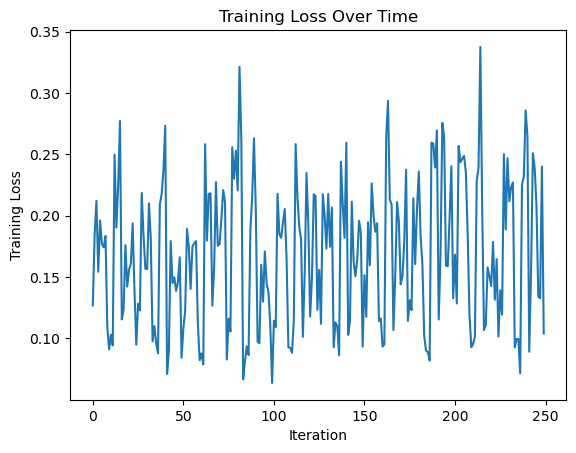

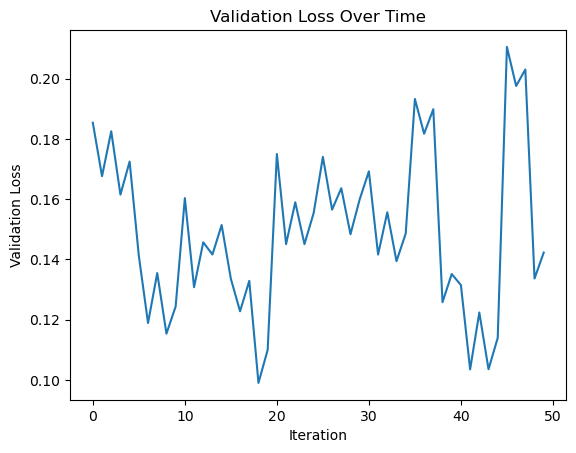

In [8]:
# Plotting losses over time
# Training
plt.plot(range(len(overall_training_loss_list)), overall_training_loss_list)
plt.title("Training Loss Over Time")
plt.xlabel("Iteration")
plt.ylabel("Training Loss")
plt.show()

# Validation
plt.plot(range(len(overall_validation_loss_list)), overall_validation_loss_list)
plt.title("Validation Loss Over Time")
plt.xlabel("Iteration")
plt.ylabel("Validation Loss")
plt.show()

## Results for the prediction task

### Results in the training dataset

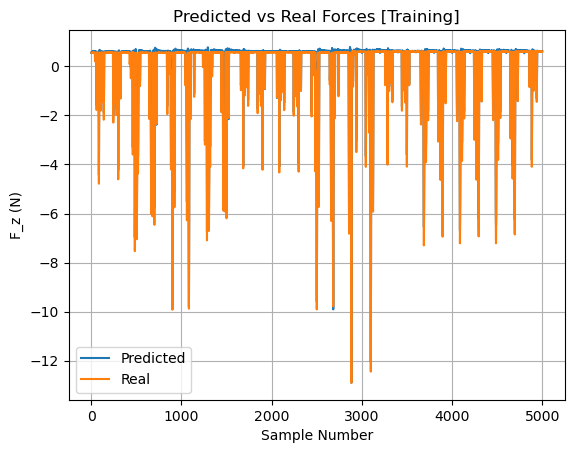

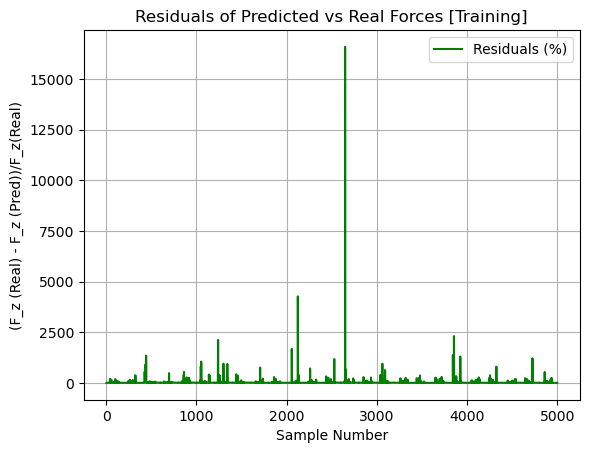

In [9]:
# Comparing predictions to real labels [Training]
# Process predictions and labels
last_epoch_training_outputs = np.array(last_epoch_training_outputs)
last_epoch_training_labels = np.array(last_epoch_training_labels)
pred_forcess = last_epoch_training_outputs * forces_z_std + forces_z_mean
forcess = last_epoch_training_labels * forces_z_std + forces_z_mean

# Plotting
plt.plot(range(1, len(pred_forcess) + 1), pred_forcess, label="Predicted")
plt.plot(range(1, len(forcess) + 1), forcess, label="Real")

# Adding title, grid, and legend
plt.title("Predicted vs Real Forces [Training]")
plt.xlabel("Sample Number")
plt.ylabel("F_z (N)")
plt.grid()
plt.legend()
plt.show()

# Plotting residuals
plt.plot(range(1, len(forcess) + 1), abs((forcess - pred_forcess)/forcess)*100, label="Residuals (%)", color='green')

# Adding title, grid, and legend
plt.title("Residuals of Predicted vs Real Forces [Training]")
plt.xlabel("Sample Number")
plt.ylabel("(F_z (Real) - F_z (Pred))/F_z(Real)")
plt.grid()
plt.legend()
plt.show()

### Results in the validation dataset

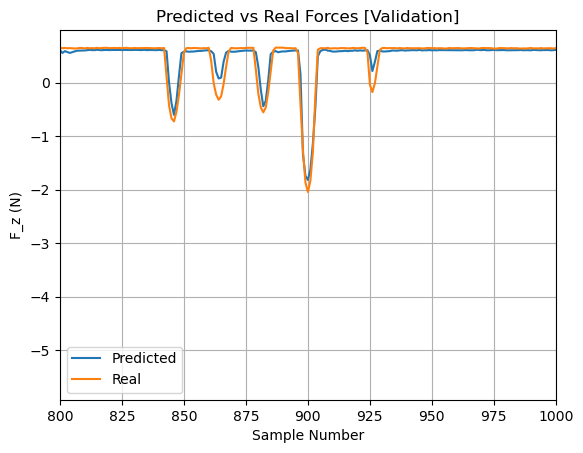

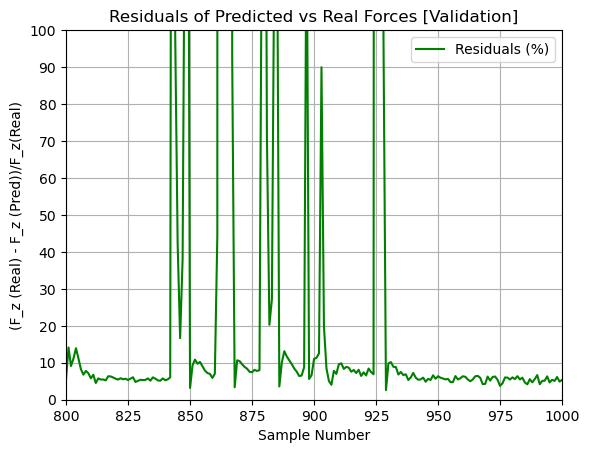

In [10]:
# Comparing predictions to real labels [Validation]
# Process predictions and labels
last_epoch_validation_outputs = np.array(last_epoch_validation_outputs)
last_epoch_validation_labels = np.array(last_epoch_validation_labels)
pred_forcess_val = last_epoch_validation_outputs * forces_z_std + forces_z_mean
forcess_val = last_epoch_validation_labels * forces_z_std + forces_z_mean

# Plotting
plt.plot(range(1, len(pred_forcess_val) + 1), pred_forcess_val, label="Predicted")
plt.plot(range(1, len(forcess_val) + 1), forcess_val, label="Real")

# Adding title, grid, and legend
plt.title("Predicted vs Real Forces [Validation]")
plt.xlabel("Sample Number")
plt.xlim(800,1000)
plt.ylabel("F_z (N)")
plt.grid()
plt.legend()
plt.show()

# Plotting residuals
plt.plot(range(1, len(forcess_val) + 1), abs((forcess_val - pred_forcess_val)/forcess_val)*100, label="Residuals (%)", color='green')

# Adding title, grid, and legend
plt.title("Residuals of Predicted vs Real Forces [Validation]")
plt.xlabel("Sample Number")
plt.xlim(800,1000)
plt.ylabel("(F_z (Real) - F_z (Pred))/F_z(Real)")
plt.ylim(0,100)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()
plt.legend()
plt.show()

### Results in the test dataset

Average RMSE on test set: 0.1286556812636802


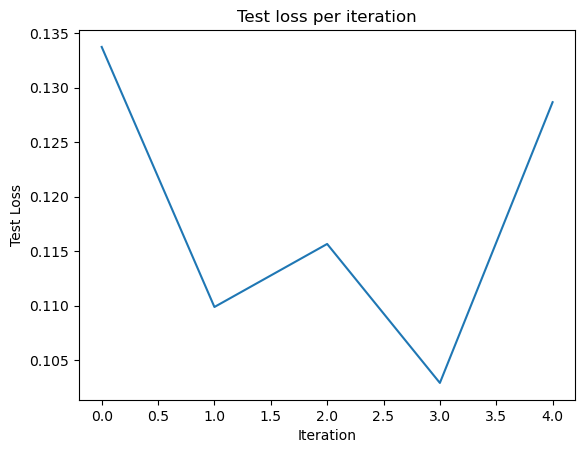

In [11]:
# Testing
if new_model_bool == 1:
    model.load_state_dict(torch.load('best_cnn_rnn_model.pth'))
else:
    model.load_state_dict(torch.load('best_model_epoch_8.pth'))
test_loss_list = []
test_outputs = []
test_labels = []
model.eval()
with torch.no_grad():
    for i in test_files_index:
        data = load_file(path, i)
        for j in range(int(file_size / batch_size)):
            # Normalize
            normalized_frames = (data['frames'][j * batch_size:(j + 1) * batch_size, :, :, :] - frames_mean) / frames_std
            normalized_forces = (data['forces'][j * batch_size:(j + 1) * batch_size, 2] - forces_z_mean) / forces_z_std

            # Create tensors
            images = torch.from_numpy(normalized_frames).float()
            labels = torch.from_numpy(normalized_forces).float()

            # Adjust dimensions
            images = images.permute(0, 3, 1, 2)

            # Forward propagation
            outputs = model(images)
            outputs = torch.squeeze(outputs)

            # Calculate loss (MSE)
            mse_loss = error(outputs, labels)

            # Store test loss (RMSE)
            rmse_loss = np.sqrt(mse_loss.data.item() * pow(forces_z_std, 2))
            test_loss_list.append(rmse_loss)

            # Store predictions and labels 
            test_outputs.extend(outputs.tolist())
            test_labels.extend(labels.tolist())

# Results 
print(f"Average RMSE on test set: {np.mean(rmse_loss)}")
plt.plot(range(len(test_loss_list)), test_loss_list)
plt.title("Test loss per iteration")
plt.xlabel("Iteration")
plt.ylabel("Test Loss")
plt.show()

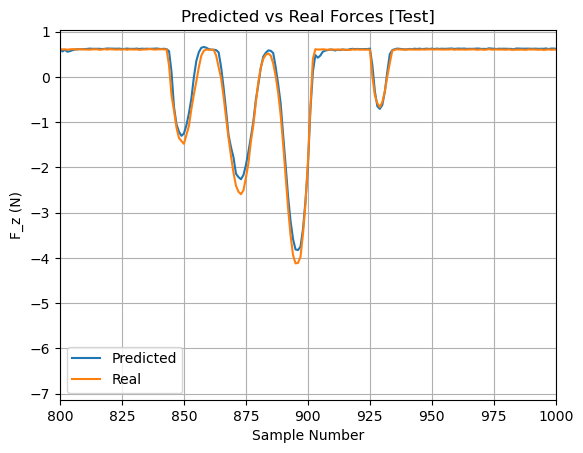

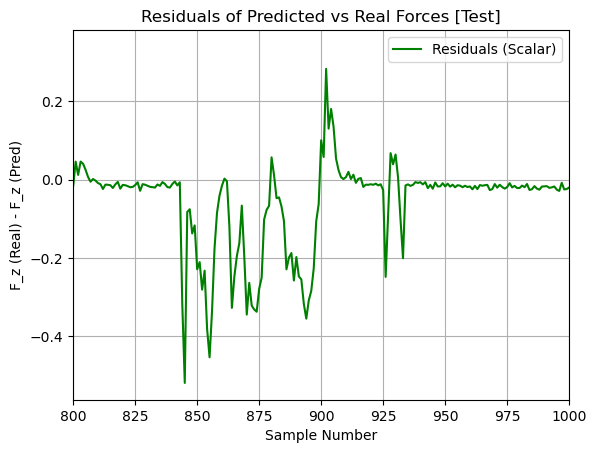

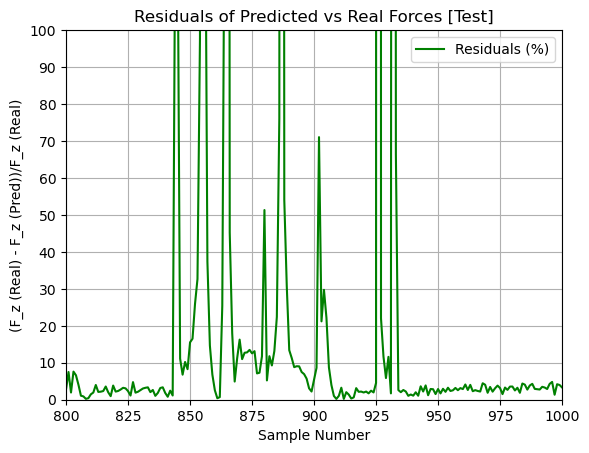

In [12]:
# Comparing predictions to real labels [Test]
# Process predictions and labels
test_outputs = np.array(test_outputs)
test_labels = np.array(test_labels)
pred_forcess_test = test_outputs * forces_z_std + forces_z_mean
forcess_test = test_labels * forces_z_std + forces_z_mean

# Plotting
plt.plot(range(1, len(pred_forcess_test) + 1), pred_forcess_test, label="Predicted")
plt.plot(range(1, len(forcess_test) + 1), forcess_test, label="Real")

# Adding title, grid, and legend
plt.title("Predicted vs Real Forces [Test]")
plt.xlabel("Sample Number")
plt.xlim(800,1000)
plt.ylabel("F_z (N)")
plt.grid()
plt.legend()
plt.show()

# Plotting residuals
plt.plot(range(1, len(forcess_test) + 1), (forcess_test - pred_forcess_test), label="Residuals (Scalar)", color='green')

# Adding title, grid, and legend
plt.title("Residuals of Predicted vs Real Forces [Test]")
plt.xlabel("Sample Number")
plt.xlim(800,1000)
plt.ylabel("F_z (Real) - F_z (Pred)")
plt.grid()
plt.legend()
plt.show()

# Plotting residuals (%)
plt.plot(range(1, len(forcess_test) + 1), abs((forcess_test - pred_forcess_test)/forcess_test)*100, label="Residuals (%)", color='green')

# Adding title, grid, and legend
plt.title("Residuals of Predicted vs Real Forces [Test]")
plt.xlabel("Sample Number")
plt.xlim(800,1000)
plt.ylabel("(F_z (Real) - F_z (Pred))/F_z (Real)")
plt.ylim(0,100)
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.grid()
plt.legend()
plt.show()

## Visualize important image features

In this section we will visualize which features from the camera images affect the most the representation of the image in the latent space.

In [8]:
# Imports
import cv2
from matplotlib.colors import Normalize as plt_norm

# Specify normalization parameters
frames_mean = 176.85697274331278
frames_std = 84.01069015654554
forces_z_mean = 0.06491058804476633
forces_z_std = 1.3482504253792438

def normalize(image, label):
    normalized_image = (image - frames_mean) / frames_std
    normalized_label = (label - forces_z_mean) / forces_z_std

    return normalized_image, normalized_label

def invNormalize(norm_image, norm_label):
    image = frames_std*norm_image + frames_mean
    label = norm_label*forces_z_std + forces_z_mean

    return image,label


def showImg(image, norm = False):
    # Image is a tensor of shape (channels, height, width)
    # if norm is true it means the image is normalized with
    # zero mean and unit std
    rgb_image = image.permute(1, 2, 0)
    rgb_image = cv2.cvtColor(np.array(rgb_image), cv2.COLOR_BGR2RGB)
    if norm:
        # plt.imshow(0.5*rgb_image+0.5)
        norm = plt_norm(vmin=-1, vmax=1, clip=True)
        rgb_image = norm(rgb_image)
        plt.imshow(rgb_image)
    else:
        plt.imshow(rgb_image.astype(int))


In [9]:
path = 'Measurements/17_05_2024 deformed membrane/attenuation 007'
file_name = 'output_batch_%d.npz'
i = 5 # batch number
file_path = os.path.join(path,file_name %i)
data = np.load(file_path)
data['frames'].shape

(1000, 270, 480, 3)

In [10]:
# Read a specific image and normalize
frame_id = 40

image = torch.from_numpy(data['frames'][frame_id]).float().permute(2, 0, 1)
label = torch.from_numpy(np.array(data['forces'][frame_id, 2])).float()

norm_image, norm_label = normalize(image,label)

Original Image


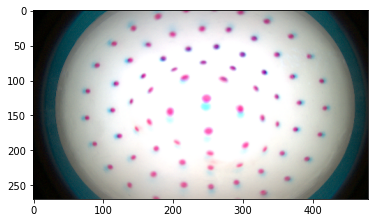

Normalized image


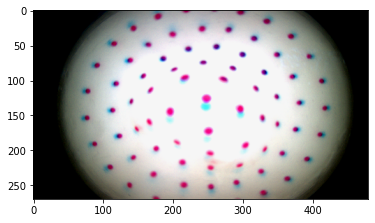

Force measurement: 3.63N


In [11]:
# Plot original and normalize image
print("Original Image")
showImg(image)
plt.show()
print("Normalized image")
showImg(norm_image,norm=True)
plt.show()

print("Force measurement: {:.2f}N".format(abs(label)))


In [12]:
# Model is already loaded as "model"
model.eval()
print(model.modules)


<bound method Module.modules of RNNModel(
  (conv1): Conv2d(3, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(9, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (rnn): RNN(8640, 200, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)>


In [13]:
model.cpu()
with torch.no_grad():
    out1 = model.conv1(norm_image)
    out2 = model.conv2(out1)

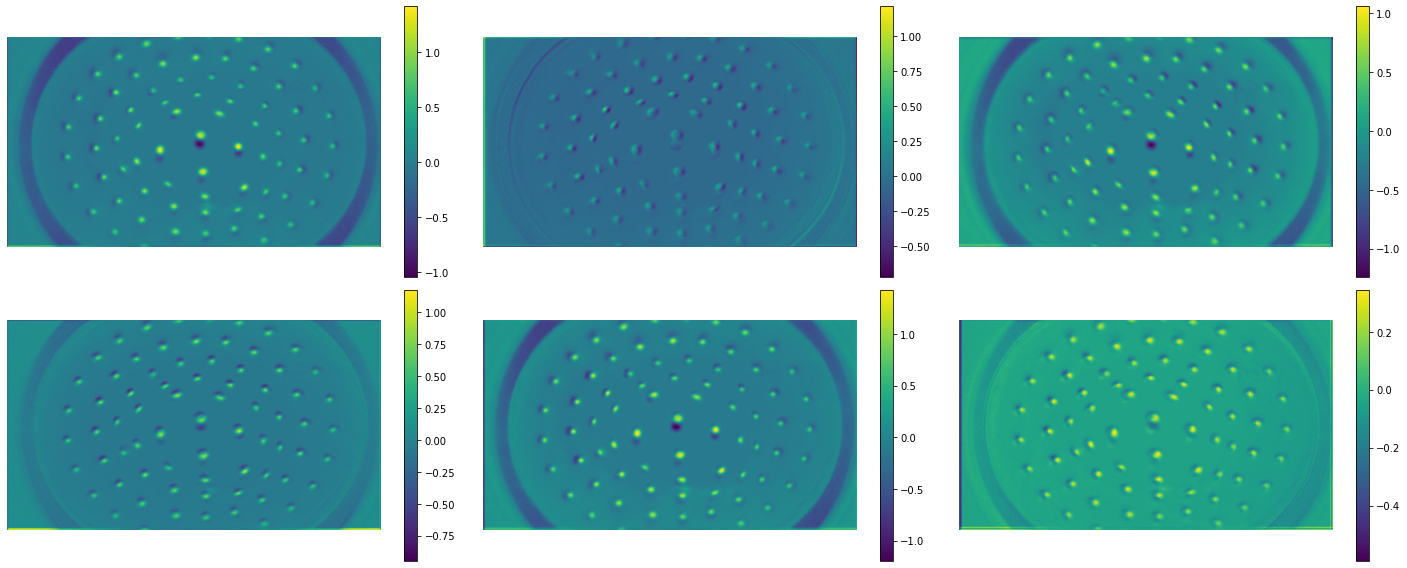

In [26]:
# Use the below to print the filters combined for each layer
# # 1st layer filters
# fig = plt.figure(figsize=(12, 8))
# rows, cols = 3, 3
# for i in range(1, (rows * cols) + 1):
#     fig.add_subplot(rows, cols, i)
#     plt.imshow(out1[i-1], cmap=plt.cm.viridis, interpolation='bilinear')
#     plt.axis('off')
#     plt.colorbar()
    
# plt.tight_layout()
# plt.show()

# # 2nd layer filters
# fig = plt.figure(figsize=(12, 16))
# rows, cols = 6, 3
# for i in range(1, (rows * cols) + 1):
#     fig.add_subplot(rows, cols, i)
#     plt.imshow(out2[i-1], cmap=plt.cm.viridis, interpolation='bilinear')
#     plt.axis('off')
#     plt.colorbar()
    
# plt.tight_layout()
# plt.show()

# Use the below to print each filter separately
# 1st layer filters
# for i in range(9):
#     print("Layer 1, filter {:}:".format(i))
#     plt.imshow(out1[i], cmap=plt.cm.viridis, interpolation='bilinear')
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()
# # 2nd layer filters
# for i in range(18):
#     print("Layer 2, filter {:}:".format(i))
#     plt.imshow(out2[i], cmap=plt.cm.viridis, interpolation='bilinear')
#     plt.axis('off')
#     plt.colorbar()
#     plt.show()

chosen = [out1[1],out2[0],out2[3],out2[5],out2[7],out2[14]]

fig = plt.figure(figsize=(20, 8))
rows, cols = 2, 3
for i in range(1, (rows * cols) + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(chosen[i-1], cmap=plt.cm.viridis, interpolation='bilinear')
    plt.axis('off')
    plt.colorbar()
    
plt.tight_layout()
plt.show()